# Adaboost реализация с нуля

![](https://thumbs.gfycat.com/GratefulFlakyKakarikis-size_restricted.gif)

src: https://gfycat.com/ru/gratefulflakykakarikis

## Ошибка

Классификация:

$$E = - \sum_{i=1}^{n}w_i \sum_{k=1}^{K}y_i^k ln y(x_i, W)$$

Регрессия:

$$ E = \frac{1}{2} \sum_{i=1}^N w_i(y_i - y(x_i, W))^2$$

Рассмотрим пример бинарной классификации на 2 класса $y_i = {1, -1}$. Тогда финальный прогноз М слабых классификаторов будет иметь вид:
$$Y(x) = sign (\sum_{j=1}^M \alpha_i y_j(x))$$

где
1. $sign$ возвращает 1, если аргумент положителен, и -1 в обратном случае
2. $\alpha_j$ - вес классификатора. Ответ классификаторов с отрицательным весом инвертируется.
3. $y_j(x)$ - прогноз алгоритма i (из М штук) на примере j (из n штук).

От голосования в случайном лесе отличается наличиев веса алгоритма $\alpha_j$.

## Один слабый классификатор

Ошибка для одного классификатора:
* $\epsilon_0 = \frac{num errors}{n}$
* $\epsilon_j = \sum_{missclaass} w_i$ или другими словами $\epsilon_j = \sum_i^n w_i^j I(y_j(x_i) \neq y_i)$, где $I(y_j(x_i) \neq y_i)$ - индикаторная функция, возвращающая 1 при ошибке классификации и 0 в обратном.

Если ошибка $0.5 \leq \epsilon_j$, то меняем прогноз на противоположный и $\epsilon_j = 1 - \epsilon_j$

---

Инициализация весов примеров:
* $w_0 = \frac{1}{n}$ для всех точек $i$
* $w_i^{j+1} = \frac{w_i^j exp(-\alpha_j I(y_j(x_i) \neq y_i))}{\sum_{i=1}^n w_i^{j+i}}$

---

Инициализация веса алгоритма:
$\alpha_j = ln\frac{1 - \epsilon_j}{\epsilon_j + 1e-5}$

1e-5 чтобы не поделить на ноль в случае нуля ошибок



Весь алгоритм выглядит так:
* Инициализировать веса $w_0$

Итерироваться $M$ раз (обучить $M$ слабых классификаторов):

1. Обучаем слабый классификатор y на взвешенной выборке
2. Вычисляем ошибку слабого классификатора
3. Вычисляем вес слабого классификатора
4. Обновляем веса $w$ элементов обучающей выборки

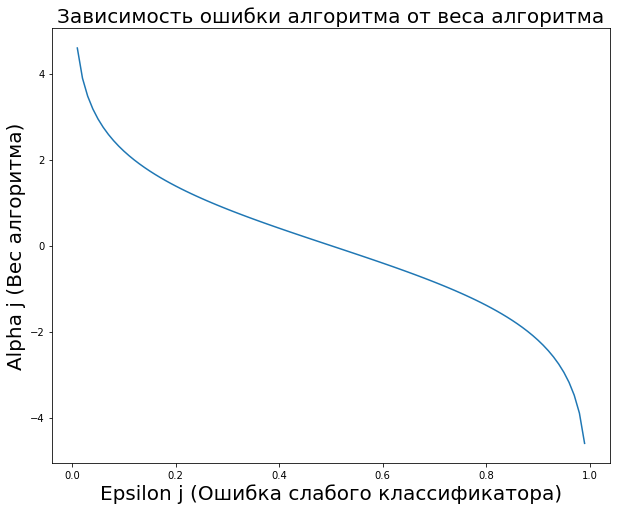

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

font = {'fontsize':20}

alpha = lambda x: np.log((1-x)/(x+1e-5))

error = np.arange(0.01, 1, 0.01)
plt.figure(figsize=(10, 8))
plt.title('Зависимость ошибки алгоритма от веса алгоритма', fontdict=font)
plt.xlabel('Epsilon j (Ошибка слабого классификатора)', fontdict=font)
plt.ylabel('Alpha j (Вес алгоритма)', fontdict=font)
plt.plot(error, alpha(error))

## Реализация алгоритма

In [ ]:
# based on https://github.com/python-engineer/MLfromscratch/blob/master/mlfromscratch/adaboost.py

# решающий пень
class DecisionStump:
    # конструктор значений по умолчанию
    def __init__(self):
        self.polarity = 1 # +1 или -1 для заданного порога
        self.feature_idx = None # выбранный индекс
        self.threshold = None # пороговое значение
        self.alpha = None # качество алгоритма

    # X: np.array - обучающая выборка
    def predict(self, X):
        n_samples = X.shape[0] # количество элементов
        X_column = X[:, self.feature_idx] # выбранный на train признак, по которому энтропия самая большая
        preds = np.ones(n_samples) # для всех ответ 1
        if self.polarity == 1: # по умолчанию
            preds[X_column < self.threshold] = -1 # если меньше порога то -1
        else:
            preds[X_column > self.threshold] = -1 # если выше порога то -1
        return preds

# адабуст на пнях
class Adaboost:
    # конструктор значений по умолчанию
    # n_clf: int количество классификаторов
    def __init__(self, n_clf = 5):
        self.n_clf = n_clf
        self.clfs = []

    # функция обучения
    # X: np.array - обучающая выборка
    # y: np.array - вектор ответов
    def fit(self, X, y):
        n_samples, n_features = X.shape # количество примеров и признаков

        # инициализация весов
        w = np.full(n_samples, (1/n_samples))

        # проходимся по всем классификаторам
        self.clfs = []
        for _ in range(self.n_clf):
            clf = DecisionStump() # инициализируем слабый классификатор

            min_error = float('inf') # лучший результат по перебору всех порогов
            for feature_i in range(n_features):
                X_column = X[:, feature_i] # для признака i
                thresholds = np.unique(X_column) # все пороги
                for threshold in thresholds: # проходимся по всем порогам
                    p = 1 # +1 по умолчанию
                    predictions = np.ones(n_samples) # все прогнозы единицы
                    predictions[X_column < threshold] = -1 # если ниже порога - левый лист

                    missclassified = w[y != predictions] # количество ошибок
                    error = sum(missclassified) # суммарная ошибка

                    if error > 0.5: # если больше 0.5 - меняем прогноз на обратный
                        error = 1 - error
                        p = -1

                    if error < min_error: # меняем порог, если нашли результат лучше
                        clf.polarity = p # +1/-1
                        clf.threshold = threshold # лучший порог
                        clf.feature_idx = feature_i # выбранный признак
                        min_error = error # лучшая ошибка

            clf.alpha = np.log((1-min_error+1e-5) / (min_error + 1e-5)) # вес алгоритма в зависимости от ошибки
            preds = clf.predict(X) # предсказания алгоритмов
            w *= np.exp(-clf.alpha * predictions) # веса примеров
            w /= np.sum(w) # нормировка весов примеров

            self.clfs.append(clf) # добавляем классификатор

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs] # умножаем вес алгоритма на его прогноз для всех классификаторов
        y_pred = np.sum(clf_preds, axis=0) # суммируем
        y_pred = np.sign(y_pred) # возвращаем +1 если положительно, -1 в обратном
        return y_pred

## Сравнение реализации с коробочным

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer() # стандартный датасет для рака груди
X = data.data # признаковое описание
y = data.target # ответы

y[y==0] = -1 # алгоритм требует разметки +- 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
clf = Adaboost(n_clf=50) # проверим для 50 пней
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
# метрики качества
print(classification_report(y_test, y_pred, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       0.78      0.95      0.86        41
      benign       0.97      0.85      0.91        73

    accuracy                           0.89       114
   macro avg       0.87      0.90      0.88       114
weighted avg       0.90      0.89      0.89       114



In [ ]:
# сравним с коробочным решением
from sklearn.ensemble import AdaBoostClassifier

clf_sklearn = AdaBoostClassifier(n_estimators=50) # If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1.
clf_sklearn.fit(X_train, y_train)
y_pred_sklearn = clf_sklearn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
# метрики качества
print(classification_report(y_test, y_pred_sklearn, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       1.00      0.97      0.99        39
      benign       0.99      1.00      0.99        75

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



# Градиентный бустинг

Имеется набор данных ${(x_i, y_i)}_{i = 1, \cdots , n}$ с дифференцируемой функцией потерь $L(y, f)$

Определим оптимальную модель как:

$$\hat{f}(x) = argmin_{f(x)} L(y, f(x)) = argmin_{f(x)} E_{x, y}[L(y, f(x))]$$

У модели есть параметры, которые мы оптимизируем ($\theta$). Говорим, что модель принадлежит некоторому параметрическому семейству $\hat{f}(x) = f(x, \theta)$

$$\theta = argmin_\theta E_{x, y}[L(t, f(x, \theta))]$$

Будем нашу модель ансамблевыми моделями:

$$\hat{f}(x) = \sum_{i=0}^{t-1}\hat{f_i}(x)$$

Т.е. каждая модель исправляет предыдущую.

Будем считать, что она минимизирует ошибку всего предыдущего ансамбля:

$$(\rho, \theta_t) = argmin_{\rho, \theta_t} E_{x, y}[L(y, \hat{f}(x) + \rho h(x, \theta))]$$

Где новая (минимизирующая ошибку ансамбля модель) $\hat{f}_t(x) = \rho_t h(x, \theta_t)$

Пусть прогноз всего ансамбля $\hat{y_i} = f_t(x_i)$, тогда градиент для точки $x_i$ будет равен $\frac{\partial L}{\partial \hat{y_i}}$.

Возьмем наиболее распространенную функция потерь $MSE$ для задачи регрессии. Тогда для нее градиент
$$\frac{\partial L}{\partial \hat{y_i}} = \frac{\partial (y_i - \hat{y_i})^2}{\partial \hat{y_i}} = -2 (y_i - \hat{y_i})$$

Тогда выражения прогноза для всех точек i для произвольной производной функции потерь имеет вид:

$$r_{it} = \[
    \frac{\partial L (y_i, f(x_i))}{\partial f(x_i)}
    \]_{f(x) = \hat{f}(x)}$$ для $i = 1, \cdots, n$.

Тогда оптимальный вектор параметров новой модели:

$$\theta_t = argmin_{\theta}\sum_i^n (r_it - h(x_i, \theta))^2$$

Т.е. минимизируется среднеквадратичное отклонение между значением минус градиента (ф-ии ошибки) и предсказаниями модели (с прошлого шага)

$$\rho_t = argmin_\rho \sum_i^n L(y_i, \hat{f}(x_i) + \rho h(x_i, \theta))$$

Продифференцировав по $\rho$ оригинальную функцию потерь $L$ добавляем новую модель в ансамбль.


В качестве изначального значения для построения моделей часто берут константу. Например, для MSE этр будет среднее значение т.к. для одной точки это

$$\frac{\partial L}{\partial \hat{y_i}} = \frac{\partial (y_i - \hat{y_i})^2}{\partial \hat{y_i}} = -2 (y_i - \hat{y_i})$$

Приравнивая минус градиент к нулю для всех точек получаем:

$$\frac{\partial L}{\partial \hat{y}} = 0$$

$-2 (y - \hat{y}) = 0$, откуда $\hat{y} = y$ т.к. нам нужно одно значение, а не вектор, то получаем, что нужно усреднить $y$.

# Данные

Анализ набора данных маркетинговых кампаний банков

https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset

Это набор данных, описывающий результаты маркетинговых кампаний португальских банков. Проведенные кампании были основаны в основном на прямых телефонных звонках, предлагающих клиенту банка разместить срочный депозит. Если после всех маркетинговых мероприятий клиент соглашался разместить депозит - целевая переменная отмечалась как "да", в противном случае - "нет".

In [ ]:
import pandas as pd

# df = pd.read_csv('https://dl.uploadgram.me/61532e4cc37bah?raw', sep=';')
df = pd.read_csv('/content/bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


<Axes: >

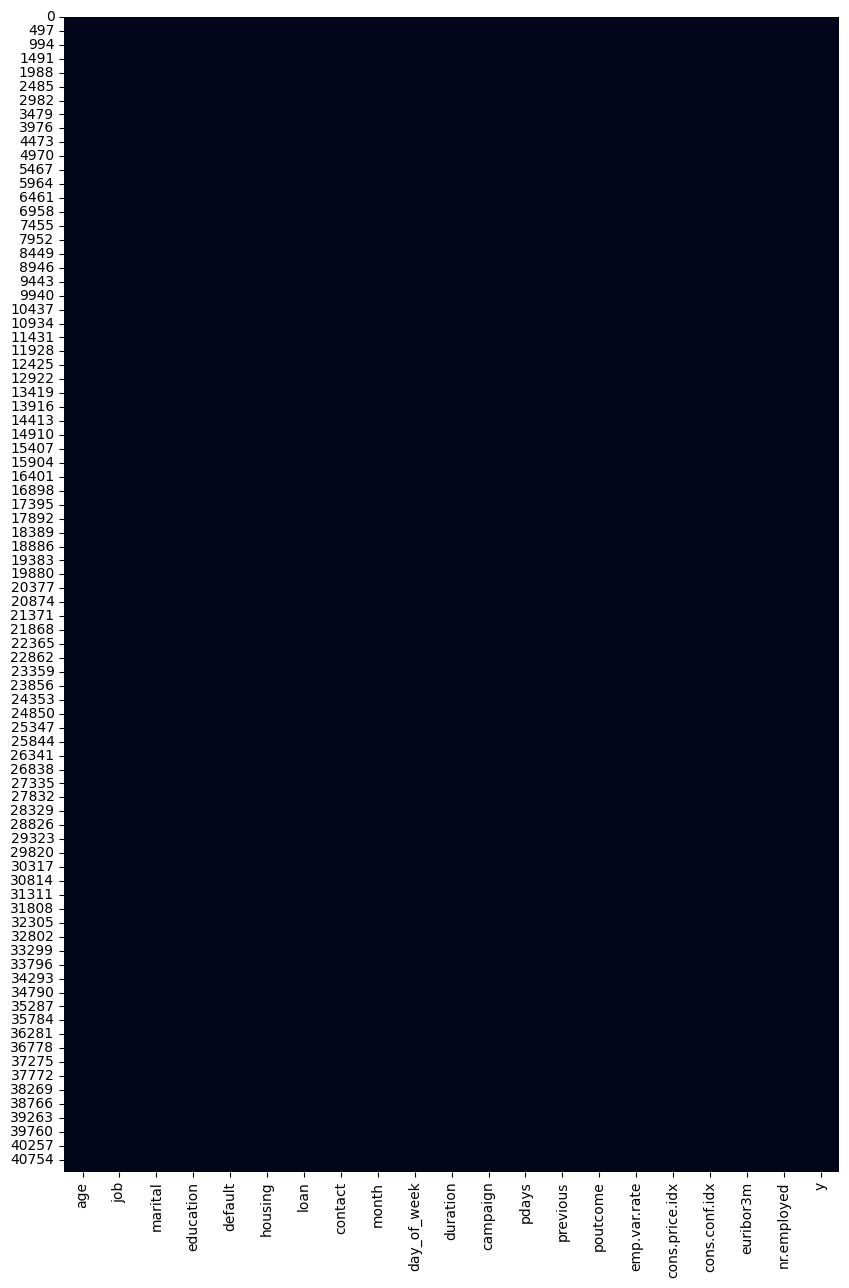

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np

figure(figsize = (10, 15))
sns.heatmap(df.isnull(), cbar=False)

<ipython-input-4-cc5d9876a6ab>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, square=True, )


<Axes: >

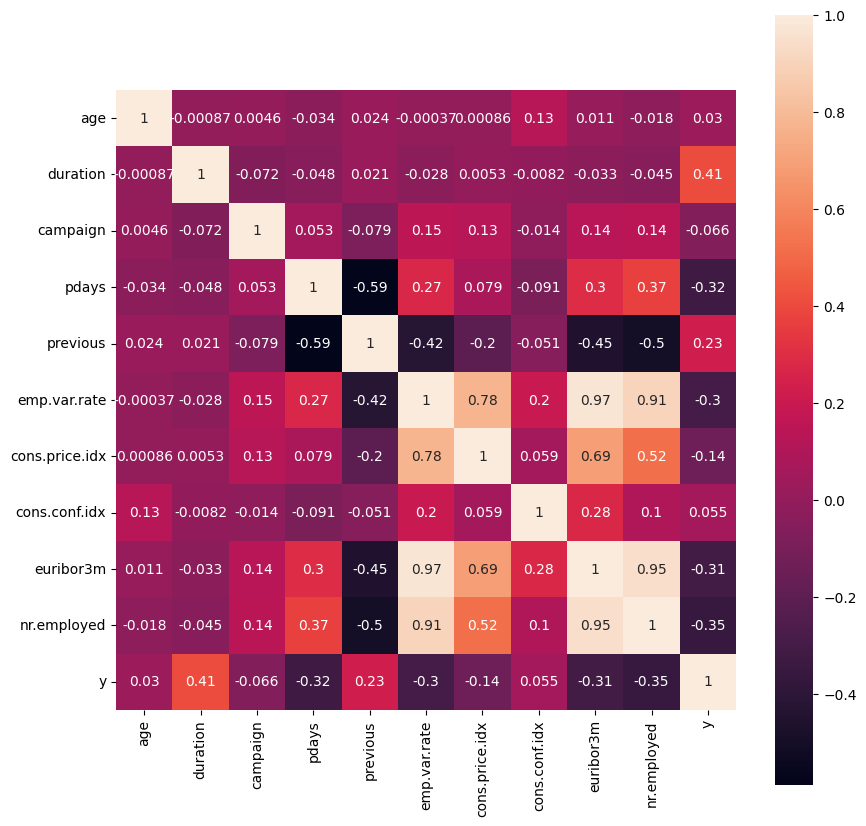

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure

df['y'] = df['y'].map({'yes':1, 'no':0})

figure(figsize = (10, 10))
sns.heatmap(df.corr(), annot=True, square=True, )

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp.var.rate'}>],
       [<Axes: title={'center': 'cons.price.idx'}>,
        <Axes: title={'center': 'cons.conf.idx'}>,
        <Axes: title={'center': 'euribor3m'}>],
       [<Axes: title={'center': 'nr.employed'}>,
        <Axes: title={'center': 'y'}>, <Axes: >]], dtype=object)

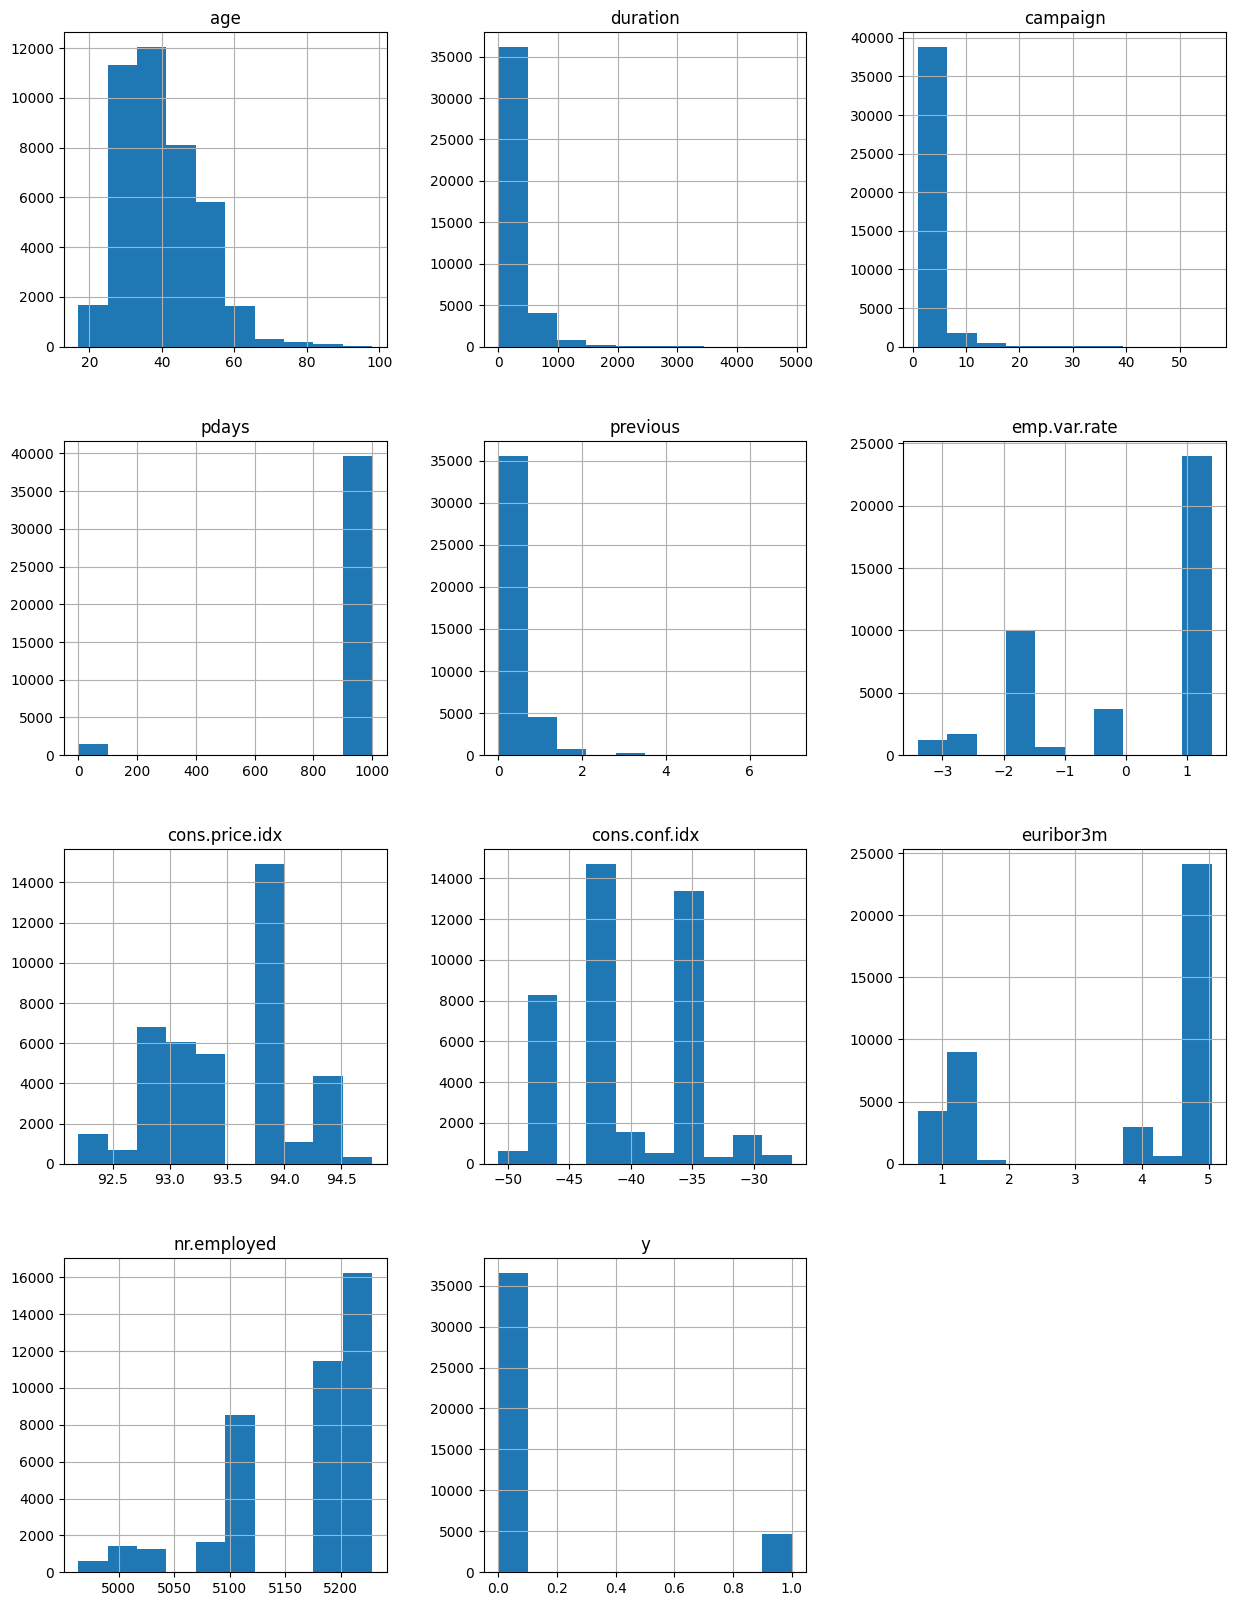

In [ ]:
df.hist(figsize=(15, 20))

In [ ]:
del df['duration'] # нам заранее не известно как долго клиент будет говорить по телефону

In [ ]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [ ]:
categor = df.select_dtypes(include=np.object) # найдем категориальные
categor

<ipython-input-8-7e4f14b50bca>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categor = df.select_dtypes(include=np.object) # найдем категориальные


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent


In [ ]:
numeric = df.select_dtypes(exclude=np.object)
numeric

<ipython-input-9-9595b32e036a>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numeric = df.select_dtypes(exclude=np.object)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# в случае, если появляется неизвестных новых - игнорируем
enc = OneHotEncoder(handle_unknown='ignore')
# выбираем какие на основе каких признаков производить преобразования
enc.fit(categor)
# производим преобразования категориальных
codes = enc.transform(categor).toarray()
# выделим названия категориальных колонок из тех, на основе которых преобразуем
feature_names = enc.get_feature_names_out(categor.columns)
# объединяем числовые и категориальные колонки

data_onehot = pd.concat([numeric, # исключаем категориальные = выбираем цифровые
                        pd.DataFrame(codes,columns=feature_names)], axis = 1) # выбираем закодированные

In [ ]:
data_onehot

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            print(column)
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df) # Теперь encoded data содержит закодированные кат. признаки

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


<ipython-input-12-8a5a1dc983e4>:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
<ipython-input-12-8a5a1dc983e4>:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
<ipython-input-12-8a5a1dc983e4>:10: DeprecationWarning: `np.object` 

In [ ]:
X = encoded_data.drop(columns=['y'])
y = encoded_data['y']

In [ ]:
X = data_onehot.drop(columns=['y'])
y = data_onehot['y']

X.shape, y.shape

((41188, 62), (41188,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 62), (8238, 62), (32950,), (8238,))

# Модели

## Лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.53      0.27      0.36       928

    accuracy                           0.89      8238
   macro avg       0.72      0.62      0.65      8238
weighted avg       0.87      0.89      0.87      8238



### Аугментации

In [ ]:
from imblearn.over_sampling import ADASYN

augm = ADASYN()
X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_augm, y_train_augm)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.96      0.94      7310
           1       0.49      0.29      0.36       928

    accuracy                           0.89      8238
   macro avg       0.70      0.63      0.65      8238
weighted avg       0.87      0.89      0.87      8238



In [ ]:
from imblearn.under_sampling import TomekLinks

augm = TomekLinks(sampling_strategy='majority')
X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_augm, y_train_augm)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7310
           1       0.51      0.32      0.40       928

    accuracy                           0.89      8238
   macro avg       0.71      0.64      0.67      8238
weighted avg       0.87      0.89      0.88      8238



## Логистическая

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train_augm, y_train_augm)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [ ]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      7310
           1       0.32      0.64      0.43       928

    accuracy                           0.81      8238
   macro avg       0.63      0.73      0.65      8238
weighted avg       0.88      0.81      0.83      8238



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
lr = LogisticRegression()
lr.fit(X_train_augm, y_train_augm)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7310
           1       0.65      0.23      0.34       928

    accuracy                           0.90      8238
   macro avg       0.78      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from imblearn.under_sampling import TomekLinks

TomekLinks

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7310
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [ ]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', probability=False),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           verbose = 2,
                           n_jobs=-1)

In [ ]:
# import joblib

# with joblib.parallel_backend('dask'):
grid_search.fit(X, y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier()

clf.fit(X_train, y_train)

BalancedRandomForestClassifier()

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7310
           1       0.32      0.68      0.44       928

    accuracy                           0.80      8238
   macro avg       0.64      0.75      0.66      8238
weighted avg       0.88      0.80      0.83      8238



## Градиентный бустинг

In [ ]:
import xgboost as xgb

param_dist = {'objective':'binary:logistic', 'n_estimators':100}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        verbose=True,)

evals_result = clf.evals_result()

[0]	validation_0-mae:0.22171
[1]	validation_0-mae:0.20310
[2]	validation_0-mae:0.18946
[3]	validation_0-mae:0.17983


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mae:0.17275
[5]	validation_0-mae:0.16747
[6]	validation_0-mae:0.16383
[7]	validation_0-mae:0.16126
[8]	validation_0-mae:0.15885
[9]	validation_0-mae:0.15745
[10]	validation_0-mae:0.15637
[11]	validation_0-mae:0.15545
[12]	validation_0-mae:0.15485
[13]	validation_0-mae:0.15450
[14]	validation_0-mae:0.15420
[15]	validation_0-mae:0.15406
[16]	validation_0-mae:0.15382
[17]	validation_0-mae:0.15381
[18]	validation_0-mae:0.15365
[19]	validation_0-mae:0.15348
[20]	validation_0-mae:0.15331
[21]	validation_0-mae:0.15338
[22]	validation_0-mae:0.15334
[23]	validation_0-mae:0.15335
[24]	validation_0-mae:0.15330
[25]	validation_0-mae:0.15327
[26]	validation_0-mae:0.15326
[27]	validation_0-mae:0.15294
[28]	validation_0-mae:0.15291
[29]	validation_0-mae:0.15281
[30]	validation_0-mae:0.15272
[31]	validation_0-mae:0.15264
[32]	validation_0-mae:0.15256
[33]	validation_0-mae:0.15256
[34]	validation_0-mae:0.15254
[35]	validation_0-mae:0.15256
[36]	validation_0-mae:0.15264
[37]	validation_

In [ ]:
print(classification_report(y_test, clf.predict(X_test.values)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.57      0.28      0.37       928

    accuracy                           0.89      8238
   macro avg       0.74      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238



In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Thu Oct 19 18:23:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1',
                             use_best_model=True,)

model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

Learning rate set to 0.052906
0:	learn: 0.6376794	test: 0.6379558	best: 0.6379558 (0)	total: 187ms	remaining: 3m 7s
1:	learn: 0.5899271	test: 0.5904776	best: 0.5904776 (1)	total: 369ms	remaining: 3m 4s
2:	learn: 0.5488768	test: 0.5497545	best: 0.5497545 (2)	total: 532ms	remaining: 2m 56s
3:	learn: 0.5135973	test: 0.5147090	best: 0.5147090 (3)	total: 703ms	remaining: 2m 54s
4:	learn: 0.4824315	test: 0.4836775	best: 0.4836775 (4)	total: 879ms	remaining: 2m 54s
5:	learn: 0.4560416	test: 0.4575486	best: 0.4575486 (5)	total: 1.03s	remaining: 2m 51s
6:	learn: 0.4327495	test: 0.4345319	best: 0.4345319 (6)	total: 1.2s	remaining: 2m 50s
7:	learn: 0.4137784	test: 0.4158471	best: 0.4158471 (7)	total: 1.36s	remaining: 2m 48s
8:	learn: 0.3973442	test: 0.3997281	best: 0.3997281 (8)	total: 1.53s	remaining: 2m 48s
9:	learn: 0.3819165	test: 0.3845256	best: 0.3845256 (9)	total: 1.6s	remaining: 2m 38s
10:	learn: 0.3683240	test: 0.3710339	best: 0.3710339 (10)	total: 1.69s	remaining: 2m 31s
11:	learn: 0.35

In [ ]:
preds = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7310
           1       0.63      0.25      0.36       928

    accuracy                           0.90      8238
   macro avg       0.77      0.62      0.65      8238
weighted avg       0.88      0.90      0.88      8238



In [ ]:
%load_ext tensorboard

In [ ]:
!mkdir models

In [ ]:
%tensorboard --logdir '/content/models/'

import os

for learning_rate in [0.001, 0.003, 0.03]:
    for depth in [4, 10, 12, 16]:
        for l2_leaf_reg in [3, 8, 15]:
            model_name = f'lr={learning_rate}_depth={depth}_l2_leaf_reg={l2_leaf_reg}'
            train_dir = '/content/models/' + model_name + '/'

            try:
                os.mkdir(train_dir)
            except:
                pass


            model = CatBoostClassifier(iterations=15000,
                                    task_type="GPU",
                                    devices='0:1',
                                    learning_rate = learning_rate,
                                    train_dir=train_dir,
                                    depth=depth,
                                    l2_leaf_reg=l2_leaf_reg)

            model.fit(X_train, y_train,
                      silent=True,
                      eval_set = (X_test, y_test),
                      early_stopping_rounds = 400)

            model.save_model(train_dir + model_name + '.cbm')

Reusing TensorBoard on port 6006 (pid 4371), started 0:00:52 ago. (Use '!kill 4371' to kill it.)

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
model = CatBoostClassifier()
model.load_model('.cbm')

In [ ]:
from catboost import Pool, CatBoostClassifier

train_dataset = Pool(X_train,
                     y_train,
                     weight=y_train.apply(lambda x: 7310./8238. if x == 1 else 928./8238.).values)

In [ ]:
# df['y'].apply(lambda x: 928./8238. if x == 1 else 7310./8238.).values

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1',
                           learning_rate = 0.03)

model.fit(train_dataset, verbose=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6826166	total: 68.1ms	remaining: 1m 8s
1:	learn: 0.6730218	total: 139ms	remaining: 1m 9s
2:	learn: 0.6637689	total: 211ms	remaining: 1m 10s
3:	learn: 0.6549890	total: 278ms	remaining: 1m 9s
4:	learn: 0.6471541	total: 340ms	remaining: 1m 7s
5:	learn: 0.6400505	total: 403ms	remaining: 1m 6s
6:	learn: 0.6333128	total: 461ms	remaining: 1m 5s
7:	learn: 0.6267917	total: 525ms	remaining: 1m 5s
8:	learn: 0.6210425	total: 583ms	remaining: 1m 4s
9:	learn: 0.6156060	total: 640ms	remaining: 1m 3s
10:	learn: 0.6102621	total: 710ms	remaining: 1m 3s
11:	learn: 0.6056044	total: 775ms	remaining: 1m 3s
12:	learn: 0.6009168	total: 826ms	remaining: 1m 2s
13:	learn: 0.5964452	total: 879ms	remaining: 1m 1s
14:	learn: 0.5924938	total: 930ms	remaining: 1m 1s
15:	learn: 0.5890341	total: 986ms	remaining: 1m
16:	learn: 0.5854344	total: 1.04s	remaining: 1m
17:	learn: 0.5820151	total: 1.09s	remaining: 59.5s
18:	learn: 0.5789901	total: 1.15s	remaining: 59.5s
19:	learn: 0.5761938	total: 1.21s	remaining: 

In [ ]:
from sklearn.metrics import classification_report
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7310
           1       0.38      0.63      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.84      0.86      8238

